> 아이티윌 데이터분석 부트캠프 52기 홍승연

## "Insurance 회귀 분석 캡스톤"

### [미션 01] "이 데이터는 믿을 만할까?"

In [1]:
# 패키지 참조하기
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas import DataFrame

# 스케일링
from sklearn.preprocessing import StandardScaler

# t-test
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind, mannwhitneyu, zscore, pearsonr, spearmanr
from statsmodels.stats.diagnostic import linear_reset
import statsmodels.api as sm
from itertools import combinations 

# 분산분석
from pingouin import anova, welch_anova
# 사후검정
from pingouin import pairwise_tukey, pairwise_gameshowell

# 선형회귀
from statsmodels.formula.api import ols
# 결과 검정
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
# VIF값 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# 그래프 초기화하기
my_dpi = 120
font_path = "./NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
sb.set_theme(style="white")
plt.rcParams['font.family'] = font_name
plt.rcParams['font.size'] = 6
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 확인하기
insurance = load_data('insurance')

print(f"데이터셋 크기: {insurance.shape}")
print(f"데이터 행 길이: {insurance.shape[0]}")
print(f"데이터 열 길이: {insurance.shape[1]}")

insurance.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.

데이터셋 크기: (1338, 7)
데이터 행 길이: 1338
데이터 열 길이: 7


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# 결측치 확인하기
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


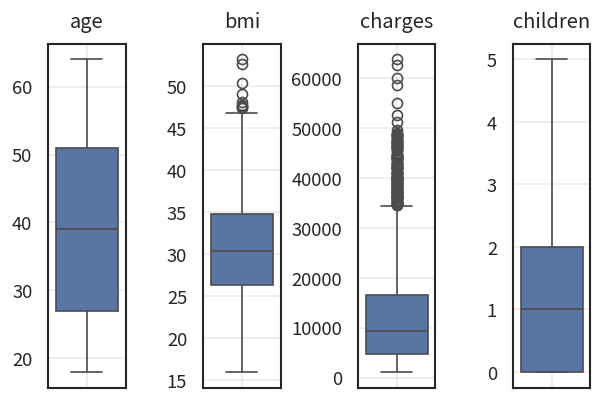

In [32]:
# 연속형 변수(age, bmi, charges) 검토하기
insurance_continuous = insurance.filter(['age', 'bmi', 'charges', 'children'])

# 1) 그래프 초기화
width_px = 600
height_px = 400
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 4, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
# [data 파라미터 활용]
# 'data': list, ndarray, Series 등 모든 연속형 객체
# 'orient': 그래프를 그릴 방향 (기본값="v")
for i, v in enumerate(insurance_continuous.columns):
    sb.boxplot(data=insurance_continuous, y=v, ax=ax[i])
    ax[i].grid(True, alpha=0.4)
    ax[i].set_ylabel('')
    ax[i].set_title(v, fontsize=12, pad=10)
 
# 3) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

In [7]:
# 연속형 변수 기초 통계량 구하기
insurance_continuous.describe()

,age,bmi,charges,children
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265,1.094918
std,14.049960,6.098187,12110.011237,1.205493
min,18.000000,15.960000,1121.873900,0.000000
25%,27.000000,26.296250,4740.287150,0.000000
50%,39.000000,30.400000,9382.033000,1.000000
75%,51.000000,34.693750,16639.912515,2.000000
max,64.000000,53.130000,63770.428010,5.000000


In [8]:
# 범주형 변수(sex, smoker, region) category 타입으로 변환하기
insurance_category = insurance.filter(['sex', 'smoker', 'region'])
insurance_category = insurance_category.astype({"sex": 'category', "smoker": 'category', "region": 'category'})
insurance_category.info()
insurance_category.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   sex     1338 non-null   category
 1   smoker  1338 non-null   category
 2   region  1338 non-null   category
dtypes: category(3)
memory usage: 4.5 KB


,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


C:\Users\itwill\AppData\Local\Temp\ipykernel_16136\297589873.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[num].set_xticklabels(labels=insurance_category[v].unique(), rotation=30)


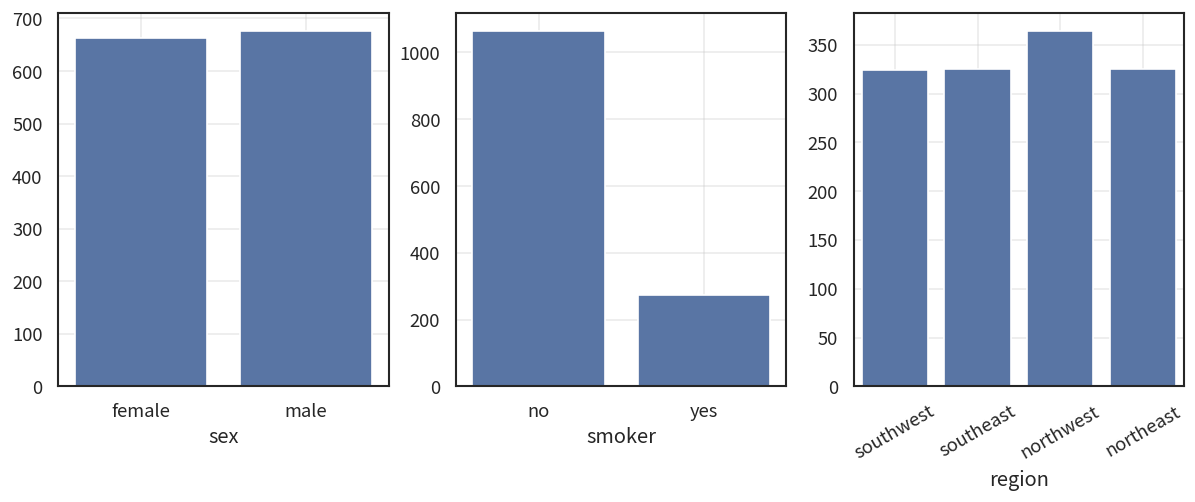

In [9]:
# 3개의 명목형 변수 카운트 플롯 그리기
# 1. 그래프 초기화
width_px = 1200
height_px = 500
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=my_dpi)

# 2. 그래프 그리기
for i, v in enumerate(insurance_category.columns):
    sb.countplot(data=insurance_category, x=v, ax=ax[i])
    ax[i].grid(True, alpha=0.4)
    ax[i].set_ylabel('')

    if len(insurance_category[v].unique()) > 3:
        num = i
        ax[num].set_xticklabels(labels=insurance_category[v].unique(), rotation=30)
    else:
        continue

# 3. 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

본 데이터의 결측치는 0개로 매우 높은 완성도(Completeness)를 보여준다. 변수는 총 7개로, 4개의 연속형과 3개의 명목형으로 이루어져있다. 연속형 변수에는 나이(age), 체질량 지수(bmi), 부양 자녀 수(children), 그리고 종속변수가 될 의료보험 청구 비용(charges)이 있으며, 명목형 변수에는 성별(sex), 흡연 여부(smoker), 미국 내 거주 지역(region) 등이 있다. 

박스 플롯과 기초통계량을 통해 연속형 변수 4개의 이상치와 편향을 확인한 결과, bmi와 charges 두 개의 변수에서는 이상치가 발견되었으며 특히 charges가 많은 이상치를 가지고 있었다. 이러한 이상치의 영향으로 charges에만 유일하게 편향이 존재하였으며, 이는 중앙값보다 평균이 더 큰 우편향에 해당했다. 즉, 대다수의 사람들보다 극단적으로 높은 보험료를 지불하는 몇몇에 의해 평균값이 많이 높아지게 된 것이다.

명목형 변수 sex, smoker, region은 각각 2, 2, 4개의 범주로 구성되어 있으며, smoker를 제외하고는 범주 간 분포가 전반적으로 고른 상태였다. smoker의 경우 담배를 피지 않는(no) 사람들의 데이터가 담배를 피는(yes) 사람들의 데이터보다 대략 5배 가량 더 많았다. 따라서 흡연 여부에 따른 의료보험 청구 비용 차이를 분석할 때는 각별한 주의가 필요할 것으로 예상된다.

### [미션 02] "의료비와 핵심 변수의 첫인상"

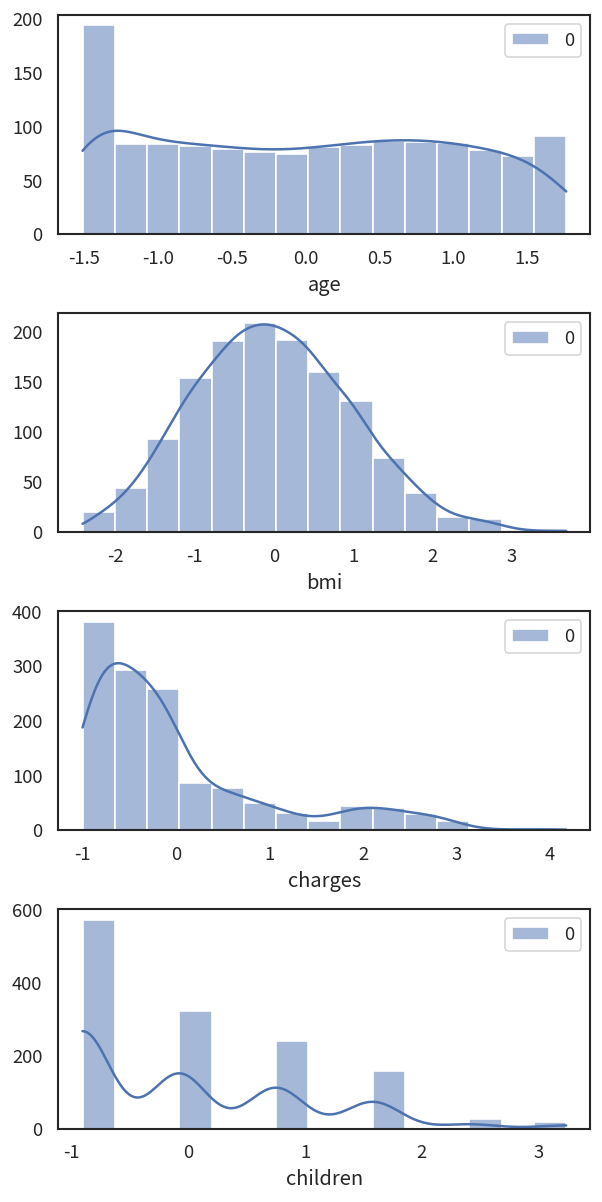

In [10]:
# 4개의 연속형 변수 히스토그램 그리기
# 1) 그래프 초기화
width_px = 600
height_px = 1200
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(4, 1, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
# [구간 수만 지정]
# 구간 범위는 Seaborn이 알아서 지정 ... (따라서 실수가 나올 가능성이 매우 큼 !!!)
# 'bins': 구간 수 지정
for i, v in enumerate(insurance_continuous.columns):
    x_input = insurance_continuous[[v]]
    scaler = StandardScaler()
    scaler_df = scaler.fit_transform(x_input)
    sb.histplot(data=scaler_df, bins=15, kde=True, ax=ax[i])
    ax[i].set_xlabel(v)
    ax[i].set_ylabel('')

# 3) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

4개의 연속형 변수를 표준화한 후 히스토그램과 KDE 선으로 시각화한 결과, bmi는 정규분포와 유사한 형태를 띄었지만 오른쪽에 약간의 꼬리가 존재했고, charges는 상당히 왼쪽으로 치우쳐 오른쪽으로 매우 긴 꼬리를 가지고 있었다. 그밖에 age와 children은 눈에 띄는 치우침이나 꼬리가 발견되지 않았고, 오히려 age의 경우 대부분의 범주에 대하여 고른 분포를 가지고 있었다.

다수의 이상치가 존재하며 쏠림 현상이 심했던 charges에 대해서는 전처리가 필요할 것으로 판단되는데, 이상치와 왜도를 동시에 해결하기 위해 로그나 제곱근 변환을 적용하는 것이 적절하다고 생각한다. 이를 통해 통계량 왜곡을 줄이고, 후에 있을 t-test와 같은 추론통계에서 믿을 만한 결과를 도출할 수 있을 것이다.

한편, bmi의 경우 최댓값보다 큰 이상치가 몇몇 존재하기는 하나 그 차이가 크지 않고 개수 역시 적어 전처리를 거치지 않아도 괜찮을 것이라고 판단하였다.

### [미션 03] "로그/비선형 변환을 고민해보자"

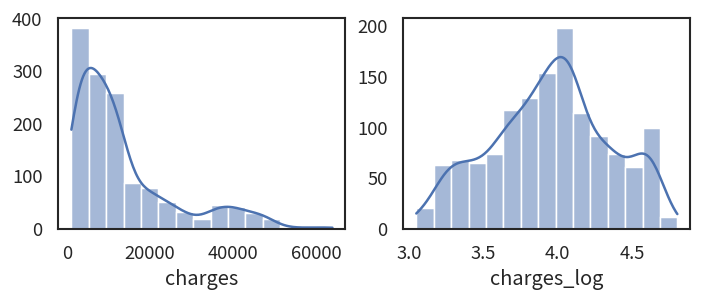

In [11]:
# charges와 log(charges) 히스토그램 비교하기
insurance_log = insurance.copy()
insurance_log['charges_log'] = np.log10(insurance_log['charges'])

# 1) 그래프 초기화
width_px = 700
height_px = 300
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
# [구간 수만 지정]
# 구간 범위는 Seaborn이 알아서 지정 ... (따라서 실수가 나올 가능성이 매우 큼 !!!)
# 'bins': 구간 수 지정
for i, v in enumerate(['charges', 'charges_log']):
    sb.histplot(data=insurance_log, x=v, bins=15, kde=True, ax=ax[i])
    ax[i].set_ylabel('')

# 3) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

앞선 미션 2에서 유일하게 이상치와 왜도가 존재했던 charges에 대해서 로그 변환을 수행한 결과, 전보다 확실히 분포가 고르게 퍼졌으며 이에 따라 이상치와 왜도 역시 없어지게 되었다. 따라서 의료보험 청구 비용에 대해서는 로그 변환을 적용하는 것이 적합하다고 볼 수 있다. 

만약 로그 변환을 적용하지 않고 원상태 그대로 분석을 진행한다면, 많은 이상치에 의해 신뢰할 수 없는 평균이 데이터를 대표한다고 착각하는 '평균의 함정'에 빠질 수 있다. 뿐만 아니라 마지막에 수행할 예측 부분에서는 왜도가 회귀 계수의 왜곡을 불러일으키고, 이는 곧 예측 모델의 정확성 감소로 이어질 가능성이 크다. 이것이 바로 본격적인 분석을 수행하기 전에 전처리를 거쳐야 하는 이유이다.

### [미션 04] "성별과 거주 지역은 의료비를 결정할까?"

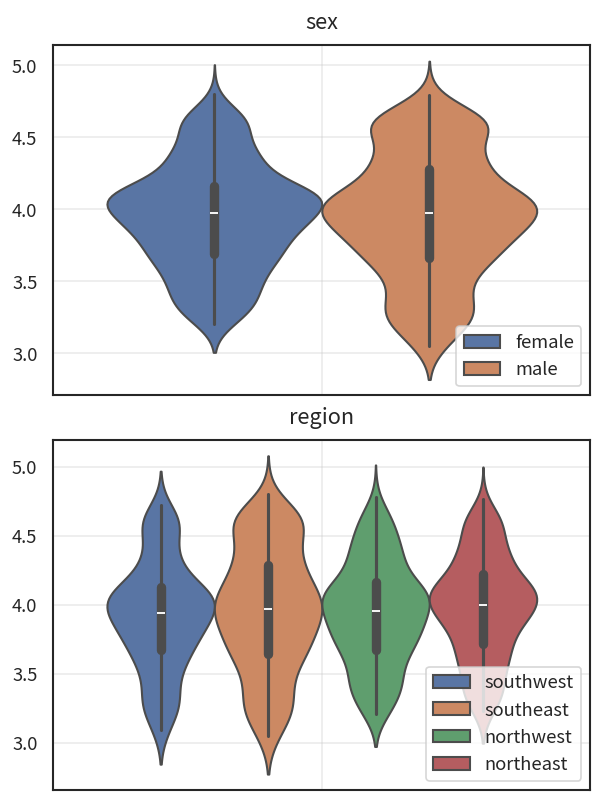

In [12]:
# hue가 성별이나 거주 지역일 때의 보험료 분포 알아보기 (바이올린 플롯)
sex_region = insurance_log.filter(['sex', 'region', 'charges_log'])

width_px = 600
height_px = 800
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(['sex', 'region']):
    sb.violinplot(data=sex_region, y='charges_log', hue=v, ax=ax[i])
    ax[i].grid(True, alpha=0.4)
    ax[i].set_ylabel('')
    ax[i].set_title(v, fontsize=13, pad=10)
    ax[i].legend(loc='lower right')

plt.tight_layout()
plt.show()
plt.close()

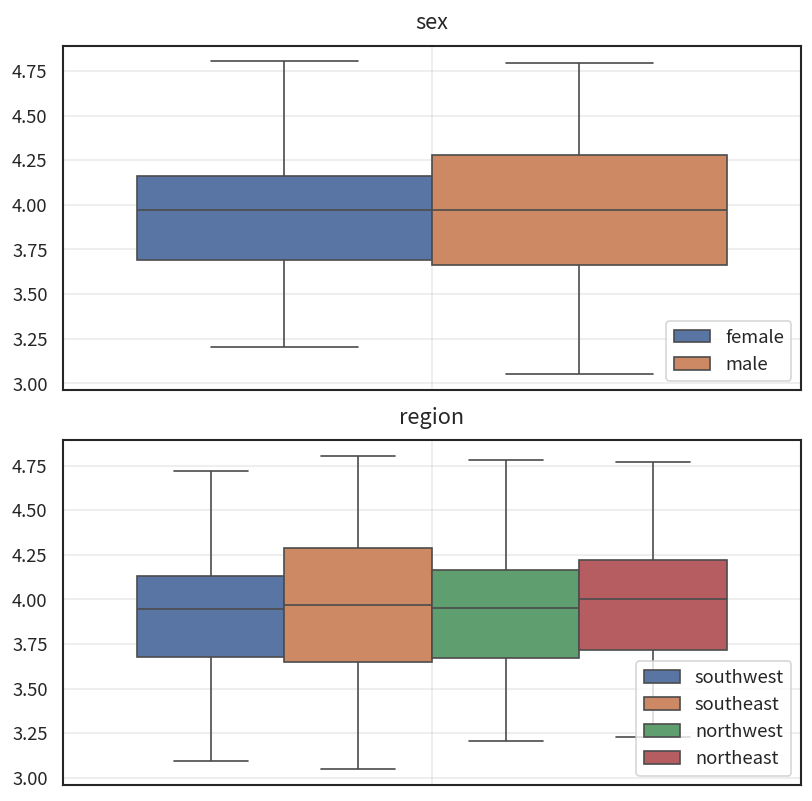

In [13]:
# hue가 성별이나 거주 지역일 때의 보험료 분포 알아보기 (박스 플롯)
sex_region = insurance_log.filter(['sex', 'region', 'charges_log'])

width_px = 800
height_px = 800
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(['sex', 'region']):
    sb.boxplot(data=sex_region, y='charges_log', hue=v, ax=ax[i])
    ax[i].grid(True, alpha=0.4)
    ax[i].set_ylabel('')
    ax[i].set_title(v, fontsize=13, pad=10)
    ax[i].legend(loc='lower right')

plt.tight_layout()
plt.show()
plt.close()

변수 sex와 region을 각 수준별로 나누어 바이올린 플롯으로 시각화 한 결과, 두 변수 모두에서 보험료의 중앙값이나 분포 차이가 거의 없는 것을 확인할 수 있었다. 믈론 region에서 southeast 지역의 사분위 수 범위가 다른 지역들에 비해 조금 더 넓은 것은 있으나, 차이가 매우 적은 편이라 그 영향은 미미할 것으로 예상된다. 따라서 성별과 거주 지역은 보험료를 결정 짓는 데 있어 중요한 요인이 아니다.

### [미션 05] "흡연은 정말로 의료비를 크게 높일까?"

In [14]:
# t-test 수행 전에 범주형 변수 인코딩하기
insurance_encoding = insurance_log.drop(columns=['charges'])
insurance_encoding['sex'] = insurance_encoding['sex'].map({"male": 0, "female": 1})
insurance_encoding['smoker'] = insurance_encoding['smoker'].map({"no": 0, "yes": 1})
insurance_encoding['region'] = insurance_encoding['region'].map({"northeast": 0, "northwest": 1, "southeast": 2, "southwest": 3})
insurance_encoding.head()

,age,sex,bmi,children,smoker,region,charges_log
0,19,1,27.900,0,1,3,4.227499
1,18,0,33.770,1,0,2,3.236928
2,28,0,33.000,3,0,2,3.648308
3,33,0,22.705,0,0,1,4.342116
4,32,0,28.880,0,0,1,3.587358


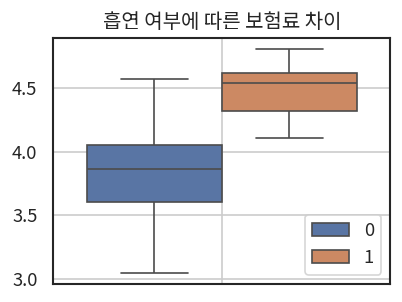

In [15]:
# 흡연 여부에 따른 보험료 차이 시각화하기 (박스 플롯)
# 1) 그래프 초기화
width_px = 400
height_px = 300
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
# [data 파라미터 활용]
# 'data': list, ndarray, Series 등 모든 연속형 객체
# 'orient': 그래프를 그릴 방향 (기본값="v")
sb.boxplot(data=insurance_encoding, y='charges_log', hue='smoker')

# 3) 그래프 꾸미기
ax.grid(True)
ax.set_ylabel('')
ax.set_title("흡연 여부에 따른 보험료 차이")
ax.legend(loc='lower right')
 
# 4) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

흡연 여부에 따른 보험료의 차이를 박스 플롯으로 시각화 한 결과, 흡연자의 보험료 중앙값이 비흡연자의 보험료 중앙값보다 대략 1.15배 더 컸다. 더욱이 흡연자의 보험료 최솟값이 비흡연자의 보험료 4사분위 수보다도 크기 때문에 두 수준 간 종속 변수의 차이는 꽤 큰 편이라고 볼 수 있다. 즉, 평균적으로 흡연자가 비흡연자보다 더 높은 의료 보험비를 지불하는 것이다.

그러나 이것만으로는 이 결과가 해당 데이터에서만 우연하게 발생한 것인지 실제로도 유의미한 것인지 알 수 없다. 따라서 추론 통계를 통해 해당 결과가 통계적으로 유의하다고 말할 수 있는지 확인할 필요가 있다.

1. 가설
    - 귀무가설(H0): 흡연 여부에 상관없이 의료 보험비는 똑같다.
    - 대립가설(H1): 흡연 여부에 따라 의료 보험비는 차이가 있다.

2. 검정 방법
> 두 독립적인 집단에 대한 평균의 차이를 비교하는 것이므로 '독립 표본 t-test'를 진행하는 것이 적절하다.

In [16]:
# 독립표본 t-test를 위해 필요한 컬럼만 남기기
ind_ttest = insurance_encoding.filter(['smoker', 'charges_log'])
ind_ttest.head()

,smoker,charges_log
0,1,4.227499
1,0,3.236928
2,0,3.648308
3,0,4.342116
4,0,3.587358


In [17]:
# 정규성 만족 여부 확인하기
normality = True
data_list = []

for yn in [0, 1]:     # no: 0, yes: 1
    data = ind_ttest.query('smoker == @yn')['charges_log']
    ts, p = normaltest(data)
    data_list.append(data)   # 후에 있을 등분산성 검정을 위한 데이터 저장
    print(f"[smoke {yn}] statistic: {ts:.3f}, p-value: {p:.3f} >>> 정규성 충족 여부: {p > 0.05}")
    normality = normality and bool(p > 0.05)

print(f">>> 해당 데이터 정규성 충족 여부: {normality}\n")

# 정규성 충족/미충족에 따라 다른 등분산성 검정 방법 적용
if normality:
    ts2, p2 = bartlett(*data_list)
    method = 'Bartlett'
else:
    ts2, p2 = levene(*data_list)
    method = 'Levene'

print(f"[{method}] statistic: {ts2:.3f}, p-value: {p2:.3f}")
print(f">>> 해당 데이터 등분산성 만족 여부: {p2 > 0.05}")

[smoke 0] statistic: 37.441, p-value: 0.000 >>> 정규성 충족 여부: False
[smoke 1] statistic: 182.430, p-value: 0.000 >>> 정규성 충족 여부: False
>>> 해당 데이터 정규성 충족 여부: False

[Levene] statistic: 89.496, p-value: 0.000
>>> 해당 데이터 등분산성 만족 여부: False


In [18]:
# 데이터가 정규성도 등분산성도 만족하지 않기 때문에 Mann-Whitney U test 진행
ts, p = mannwhitneyu(ind_ttest.query('smoker == 0')['charges_log'], 
                     ind_ttest.query('smoker == 1')['charges_log']
)
print(f"statistic: {ts:.3f}, p-value: {p:.3f} >>> {'귀무' if p > 0.05 else '대립'}가설 채택 !")

statistic: 7403.000, p-value: 0.000 >>> 대립가설 채택 !


독립표본 t-test 검정 결과, p-value가 유의수준 0.05보다 작기 때문에 흡연 여부에 따라 의료 보험비에는 차이가 있다는 대립가설을 채택해야 한다.

In [19]:
# 이제 어떤 경우가 더 비싼지/싼지 확인
# H0: 비흡연자의 의료 보험비가 흡연자의 의료 보험비보다 싸지 않다.
# H0: 비흡연자의 의료 보험비가 흡연자의 의료 보험비보다 싸다.
ts, p = mannwhitneyu(ind_ttest.query('smoker == 0')['charges_log'], 
                     ind_ttest.query('smoker == 1')['charges_log'],
                     alternative='less'
)
print(f"statistic: {ts:.3f}, p-value: {p:.3f} >>> {'귀무' if p > 0.05 else '대립'}가설 채택 !")

statistic: 7403.000, p-value: 0.000 >>> 대립가설 채택 !


독립표본 t-test 검정 결과, p-value가 유의수준 0.05보다 작기 때문에 대립가설을 채택해야 한다.

즉, 유의수준 5%에서 비흡연자의 의료 보험비가 흡연자의 의료 보험비보다 통계적으로 유의하게 더 싸다.

### [미션 06] "나이대별로 의료비 차이가 뚜렷할까?"

1. 가설
- 귀무가설(H0): 3가지 연령대별 평균 의료 보험비는 다르지 않다.
- 대립가설(H1): 3가지 연령대의 평균 의료 보험비 중 하나라도 다르다.

2. 검정 방법

> age이라는 하나의 요인에 대한 3개 이상 집단의 평균 차이를 비교하는 것이므로 '일원분산분석(One-way ANOVA)'를 진행하는 것이 적절하다.

In [20]:
# 일원분산분석을 위해 필요한 컬럼만 남기기
oneway_anova = insurance_encoding.filter(['age', 'charges_log'])

oneway_anova.loc[oneway_anova['age'] < 31, 'age'] = 0
oneway_anova.loc[(oneway_anova['age'] >= 31) & (oneway_anova['age'] <= 50), 'age'] = 1
oneway_anova.loc[oneway_anova['age'] > 50, 'age'] = 2

oneway_anova = oneway_anova.astype({"age": 'category'})
print(oneway_anova['age'].describe(include='category'))
display(oneway_anova)

count     1338
unique       3
top          1
freq       538
Name: age, dtype: int64


,age,charges_log
0,0,4.227499
1,0,3.236928
2,0,3.648308
3,1,4.342116
4,1,3.587358
...,...,...
1333,1,4.025328
1334,0,3.343602
1335,0,3.212143
1336,0,3.302752


In [21]:
# 데이터 정규성 및 등분산성 확인
age_group = [0, 1, 2]
data_list = []
normality = True

for age in age_group:
    data = oneway_anova.query('age == @age')['charges_log']
    data_list.append(data)

    fs, p = normaltest(data)
    print(f"[연령 그룹 {age}] statistic: {fs:.3f}, p-value: {p:.3f} >>> 정규성 충족 여부: {p > 0.05}")
    normality = normality and bool(p > 0.05)

print(f">>> 해당 데이터 정규성 충족 여부: {normality}\n")

if normality:
    fs2, p2 = bartlett(*data_list)
    method = 'Bartlett'
else:
    fs2, p2 = levene(*data_list)
    method = 'Levene'

print(f"[{method}] statistic: {fs2:.3f}, p-value: {p2:.3f}")
print(f">>> 해당 데이터 등분산성 만족 여부: {p2 > 0.05}")

[연령 그룹 0] statistic: 87.097, p-value: 0.000 >>> 정규성 충족 여부: False
[연령 그룹 1] statistic: 59.700, p-value: 0.000 >>> 정규성 충족 여부: False
[연령 그룹 2] statistic: 61.816, p-value: 0.000 >>> 정규성 충족 여부: False
>>> 해당 데이터 정규성 충족 여부: False

[Levene] statistic: 78.720, p-value: 0.000
>>> 해당 데이터 등분산성 만족 여부: False


In [22]:
# 정규성 및 등분산성 미충족으로 welch_anova()를 활용한 분산분석 실시
cut_anova = welch_anova(data=oneway_anova, dv='charges_log', between='age')
cut_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,age,2,844.381463,213.677101,8.127056e-76,0.241082


일원분산분석 결과, p-value가 유의수준 0.05보다 작기 때문에 3가지 연령대의 평균 의료 보험비 중 하나라도 다르다는 대립가설을 채택한다.

In [23]:
# 어떻게 다른지 확인하기 위해 사후검정 실시
age_test = pairwise_gameshowell(data=oneway_anova, dv='charges_log', between='age')
age_test

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,0,1,3.695604,4.002162,-0.306558,0.025709,-11.924358,725.803502,2.062794e-13,-0.795140
1,0,2,3.695604,4.194078,-0.498474,0.024960,-19.971255,650.218082,5.995204e-14,-1.320925
2,1,2,4.002162,4.194078,-0.191916,0.017235,-11.135340,886.616801,0.000000e+00,-0.711652


사후검정을 통해 연령대별 의료 보험료를 비교해본 결과, 의료 보험료의 평균 가격은 ‘연령 그룹 0 < 연령 그룹 1 < 연령 그룹 2’ 순으로 높은 것으로 나타났다. 다시 말해 연령대가 높을수록 보험료도 높은 경향이 있는 것이다. 더불어 연령 그룹 0과 1, 1과 2 사이의 평균 차이가 비슷한 것으로 보아 연령에 따라 정해지는 기본 보험료가 있다는 추론을 해볼 수도 있다.

> 추가: 나이가 대략적인 기본 보험료를 정하는 1순위(?) 기준이라고 볼 수 있는가?

또한, 모든 수준 쌍 비교에서 p-value가 유의수준 0.05보다 작기 때문에 연령대별 보험료 차이는 통계적으로 유의하며, 효과 크기 역시 모두 절댓값 0.7 이상으로 큰 편에 속한다. 따라서 연령이 보험료를 결정하는 주요 요인 중 하나라고 볼 수 있다.

> 추가: 현재 연령 그룹 간 나이 차이가 꽤 큰데, 만약 그 차이를 줄일 경우(ex. 10살 단위, 5살 단위. …) 결과가 어떻게 달라지는지 확인해볼 필요가 있다. 몇 살 단위 차이까지 나이에 따른 보험료가 다른가?

### [미션 07] "변수들은 서로 섞여 있을까?"